# Import libraries 

In [36]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Other
import h5py

# Set seed

In [37]:
key = jax.random.PRNGKey(42)

# Set device type

In [ ]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
device = gpu if gpu is not None else cpu
jax.default_device(device)
backend = jax.default_backend()

print(backend)

METAL:0
METAL


# Import training data

In [4]:
# Path to the new HDF5 file
file_path = "../data/SIM/simulations_10000_500_S_full.h5"

with h5py.File(file_path, "r") as f:
    # Parameters: load directly as (N,) JAX arrays
    params = {key: jnp.array(f[f"params/{key}"][:]) for key in f["params"].keys()}

    # Data columns: load directly as (N, M) JAX arrays
    data = {col: jnp.array(f[f"data/{col}"][:]) for col in f["data"].keys()}


# Number of simulations and SNe per simulation
N = next(iter(params.values())).shape[0]   # N simulations
M = next(iter(data.values())).shape[1]     # M SNe per simulation

print(f"The file contains {N} simulations of size {M}")

The file contains 10000 simulations of size 500


In [5]:
# Example usage
print(params['alpha'].shape)   # (N,)
print(data['magobs'].shape)    # (N, M)

(10000,)
(10000, 500)


# Compute residuals

In [6]:
magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

mu_planck18, data['magobs']= nntr.rm_cosmo(data['z'], data['magobs'], n_grid=10_000)

# Only update 'mabs' if it exists in params
if 'mabs' in params:
    params['mabs'] = params['mabs'] + 19.3

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


In [7]:
# Apply mask
# Masked version (NaNs)
data_filt = {k: jnp.where(mask, v, jnp.nan) for k, v in data.items()}

# Padded version (zeros)
data_padded = {k: jnp.where(mask, v, 0) for k, v in data.items()}

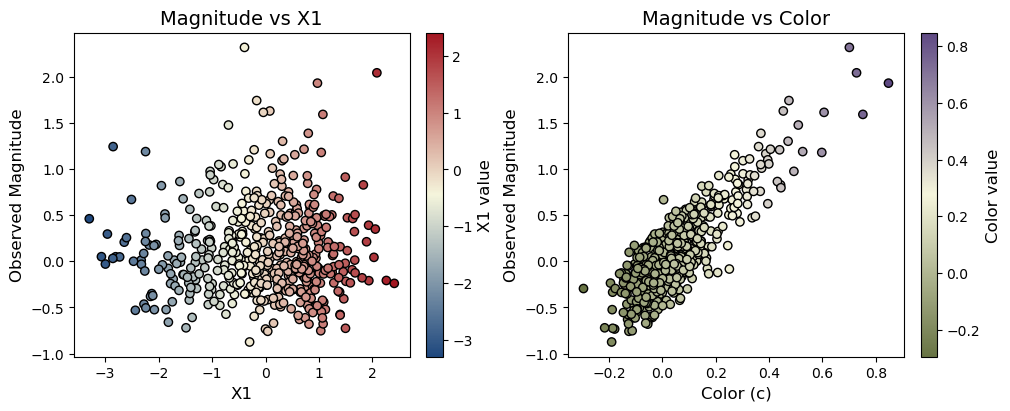

In [8]:
index = 5  # index for your data slice

# Define the color maps
cmap1 = LinearSegmentedColormap.from_list(
    'custom_red_beige_blue',
    ['#1F487E', 'beige', '#A31621']
)

cmap2 = LinearSegmentedColormap.from_list(
    'custom_green_beige_purple',
    ['#687444', 'beige', '#5E4983']
)

# Create figure and horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# First subplot: x1 vs magobs
sc1 = axes[0].scatter(data_filt['x1'][index, :], data_filt['magobs'][index, :], c=data_filt['x1'][index, :], cmap=cmap1, edgecolor='k')
axes[0].set_title('Magnitude vs X1', fontsize=14)
axes[0].set_xlabel('X1', fontsize=12)
axes[0].set_ylabel('Observed Magnitude', fontsize=12)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('X1 value', fontsize=12)

# Second subplot: c vs magobs
sc2 = axes[1].scatter(data_filt['c'][index, :], data_filt['magobs'][index, :], c=data_filt['c'][index, :], cmap=cmap2, edgecolor='k')
axes[1].set_title('Magnitude vs Color', fontsize=14)
axes[1].set_xlabel('Color (c)', fontsize=12)
axes[1].set_ylabel('Observed Magnitude', fontsize=12)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Color value', fontsize=12)

plt.show()


# Prepare train and test sets

## Set bounds

In [9]:
bounds = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

## Label data

In [10]:
# K = len(params)  # number of parameters

# key, lhs_key = jax.random.split(key)
# lhs_samples = nntr.lhs_jax(lhs_key, K, N)   # shape (N, K)

# # Convert bounds to arrays
# param_names = list(params.keys())
# mins = jnp.array([bounds[name]['min'] for name in param_names])
# maxs = jnp.array([bounds[name]['max'] for name in param_names])

# false_params = mins + (maxs - mins) * lhs_samples  # shape (N,K)

# # Masking: produce N×K array of masked parameters
# key, label_key = jax.random.split(key)
# labels = jax.random.uniform(label_key, (N,)) > 0.5  # (N,)

# param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)
# param_masked = jnp.where(labels[:, None], param_true, false_params)  # (N,K)

In [11]:
K = len(params)  # number of parameters

key, lhs_key = jax.random.split(key)
lhs_samples = nntr.lhs_jax(lhs_key, K, N)   # shape (N, K)

# Convert bounds to arrays
param_names = list(params.keys())
mins = jnp.array([bounds[name]['min'] for name in param_names])
maxs = jnp.array([bounds[name]['max'] for name in param_names])

false_params = mins + (maxs - mins) * lhs_samples  # shape (N,K)

# ----- True parameters -----
param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)

# ----- 20% mask -----
key, label_key = jax.random.split(key)
label_mask = jax.random.uniform(label_key, (N,)) < 0.5  # True = use true params

# ----- Parameters after masking -----
param_masked = jnp.where(label_mask[:, None], param_true, false_params)  # (N,K)

# ----- Scalar labels -----
# Gaussian width = 2% of prior range
sigma = 0.4 * (maxs - mins)  # (K,)

# Compute squared distance from truth
diff = (param_masked - param_true) / sigma  # (N,K)
sqdist = jnp.sum(diff**2, axis=1)           # (N,)

# Gaussian classifier label
labels_gauss = jnp.exp(-0.5 * sqdist)       # (N,)

# Final labels: true=1 for the 20%
labels = jnp.where(label_mask, 1.0, labels_gauss)


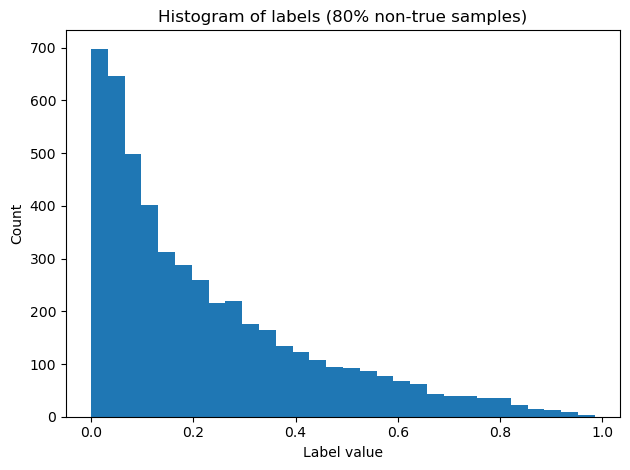

In [12]:
# 80% non-true samples
labels_80 = labels[~label_mask]

plt.figure()
plt.hist(labels_80, bins=30)         # no color specifications unless you ask
plt.xlabel("Label value")
plt.ylabel("Count")
plt.title("Histogram of labels (80% non-true samples)")
plt.tight_layout()
plt.show()


In [13]:
# print(0.5 + jnp.mean(labels)/2)

## Concatenate data

In [14]:
# -----------------------------
# 1. Prepare data arrays
# -----------------------------
data_names = list(data_padded.keys())        # list of C "columns"
n_cols = len(data_names)                     # number of features per element

# Create a list of (N, M) arrays
data_arrays = [data_padded[name] for name in data_names]

# Concatenate along last axis to form (N, M*n_cols)
data_concat = jnp.concatenate(data_arrays, axis=-1)

# Ensure mask and parameters are in the correct shape
inputs = jnp.concatenate([data_concat, mask, param_masked], axis=-1)

# Output labels
outputs = labels.astype(jnp.int32)[:, None]

print("Input shape:", inputs.shape)    # (N, M*n_cols + M + n_params)
print("Output shape:", outputs.shape)  # (N, 1)

# -----------------------------
# 2. Split train/test
# -----------------------------
key, split_key = jax.random.split(key)
train_data, test_data, train_labels, test_labels = nntr.train_test_split_jax(
    inputs, outputs, test_size=0.3, shuffle=True, key=split_key
)

# Move to device
train_data = jax.device_put(train_data)
train_labels = jax.device_put(train_labels)
test_data = jax.device_put(test_data)
test_labels = jax.device_put(test_labels)

print("Train/test split done. Shapes:")
print("train_data:", train_data.shape)
print("train_labels:", train_labels.shape)
print("test_data:", test_data.shape)
print("test_labels:", test_labels.shape)


Input shape: (10000, 5504)
Output shape: (10000, 1)
Train/test split done. Shapes:
train_data: (7000, 5504)
train_labels: (7000, 1)
test_data: (3000, 5504)
test_labels: (3000, 1)


# Build a neural network

In [16]:
class Phi(nnx.Module):
    """
    Neural network module for the Phi network in a Deep Set architecture.
    """
    def __init__(self, Nsize, n_cols, *, rngs):
        """
        Initialize the Phi network.

        Parameters
        ----------
        Nsize : int
            Size of the hidden layers.
        n_cols : int
            Number of input columns (features).
        rngs : nnx.Rngs
            Random number generators.
        """
        self.linear1 = nnx.Linear(n_cols, Nsize, rngs=rngs)
        self.linear2 = nnx.Linear(Nsize, Nsize, rngs=rngs)

    def __call__(self, x):
        """
        Forward pass of the Phi network.

        Parameters
        ----------
        x : array-like
            Input data.

        Returns
        -------
        array-like
            Output of the Phi network.
        """
        h = nnx.relu(self.linear1(x))
        h = nnx.relu(self.linear2(h))
        return h


class Rho(nnx.Module):
    """
    Neural network module for the Rho network in a Deep Set architecture.
    """
    def __init__(self, Nsize_p, Nsize_r, n_params, *, rngs):
        """
        Initialize the Rho network.

        Parameters
        ----------
        Nsize_p : int
            Size of the pooled features.
        Nsize_r : int
            Size of the hidden layers in Rho.
        n_params : int
            Number of parameters (theta).
        rngs : nnx.Rngs
            Random number generators.
        """
        self.norm = nnx.LayerNorm(Nsize_p + n_params, rngs=rngs)
        self.linear1 = nnx.Linear(Nsize_p + n_params, Nsize_r, rngs=rngs)
        self.linear2 = nnx.Linear(Nsize_r, 1, rngs=rngs)

    def __call__(self, dropout, pooled_features, theta):
        """
        Forward pass of the Rho network.

        Parameters
        ----------
        dropout : nnx.Dropout
            Dropout layer.
        pooled_features : array-like
            Pooled features from the Phi network.
        theta : array-like
            Parameter values.

        Returns
        -------
        array-like
            Output of the Rho network (logits).
        """
        x = jnp.concatenate([pooled_features, theta], axis=-1)
        # x = self.norm(x)
        x = nnx.relu(self.linear1(x))
        x = dropout(x)
        return self.linear2(x)



class DeepSetClassifier(nnx.Module):
    """
    Deep Set Classifier model combining Phi and Rho networks.
    """
    def __init__(self, dropout_rate, Nsize_p, Nsize_r,
                 n_cols, n_params, *, rngs):
        """
        Initialize the Deep Set Classifier.

        Parameters
        ----------
        dropout_rate : float
            Dropout rate.
        Nsize_p : int
            Size of the Phi network output.
        Nsize_r : int
            Size of the Rho network hidden layers.
        n_cols : int
            Number of input columns per element.
        n_params : int
            Number of parameters (theta).
        rngs : nnx.Rngs
            Random number generators.
        """

        self.dropout = nnx.Dropout(rate=dropout_rate, rngs=rngs)
        self.n_cols   = n_cols
        self.n_params = n_params

        self.phi = Phi(Nsize_p, n_cols, rngs=rngs)
        self.rho = Rho(Nsize_p, Nsize_r, n_params, rngs=rngs)

    def __call__(self, input_data):
        """
        Forward pass of the Deep Set Classifier.

        Parameters
        ----------
        input_data : array-like
            Input data containing set elements and parameters.

        Returns
        -------
        array-like
            Model output (logits).
        """
        N, input_dim = input_data.shape

        # Compute M first from input size
        # Total input columns = M*n_cols + n_params + M (mask)
        M = (input_dim - self.n_params) // (self.n_cols + 1)

        # Reshape data columns
        data = input_data[:, :M*self.n_cols].reshape(N, M, self.n_cols)

        # Slice mask (last M columns)
        mask = input_data[:, -M-self.n_params:-self.n_params]         # shape (N, M)

        # Parameters
        theta = input_data[:, -self.n_params:]  # shape (N, n_params)

        # print(theta)

        # Apply Phi
        h = self.phi(data)

        # Apply mask
        h_masked = h * mask[..., None]

        # Pool (masked average)
        mask_sum = jnp.sum(mask, axis=1, keepdims=True)
        mask_sum = jnp.where(mask_sum == 0, 1.0, mask_sum)
        pooled = jnp.sum(h_masked, axis=1) # / mask_sum # Try jnp.sqrt(mask_sum) ?

        # Apply Rho
        return self.rho(self.dropout, pooled, theta)

In [15]:
# Define the size of the different network layers
Nsize_p = 64 #32 #64 #128
Nsize_r = 256 #128 #1024 #2048

n_cols = len(data_names)
print('# of columns :', n_cols)
n_params = len(param_names)
print('# of params :', n_params)

model_config = {
    'Nsize_p': Nsize_p,
    'Nsize_r': Nsize_r,
    'n_cols' : n_cols,
    'n_params': n_params
}

# of columns : 10
# of params : 4


In [17]:
model = DeepSetClassifier(0.05, Nsize_p, Nsize_r, n_cols, n_params, rngs=nnx.Rngs(0))

# Visualize the model structure
nnx.display(model)

In [18]:
# Initialise metrics history
metrics_history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

In [19]:
n_batch = 40

# Define the learning rate schedule 
learning_rate_schedule = optax.exponential_decay(
    init_value=5e-4,
    transition_steps=1000,  # Decay every 1000 forward passes
    decay_rate=0.9,
)

momentum = 0.9 # Necessary for the Adam optimiser

In [20]:
# Initialize optimiser with the adaptive learning rate
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate_schedule, momentum))

In [21]:
# # Initialize optimiser with the stochastic gradient descent
# optimizer = nnx.Optimizer(model, optax.sgd(learning_rate_schedule, momentum))

In [22]:
# sched1 = optax.linear_schedule(
#     init_value=1e-4,
#     end_value=1e-3,
#     transition_steps=500
# )

# sched2 = optax.linear_schedule(
#     init_value=1e-3,
#     end_value=1e-5,
#     transition_steps=1500
# )

# schedule = optax.join_schedules(
#     schedules=[sched1, sched2],
#     boundaries=[1000]      # switch from schedule 1 to 2 at step 500
# )

# # Initialize optimiser with the adaptive learning rate
# optimizer = nnx.Optimizer(model, optax.sgd(schedule, momentum=0.9))

# Train NN

In [23]:
print(train_data.device)
print(train_labels.device)

METAL:0
METAL:0


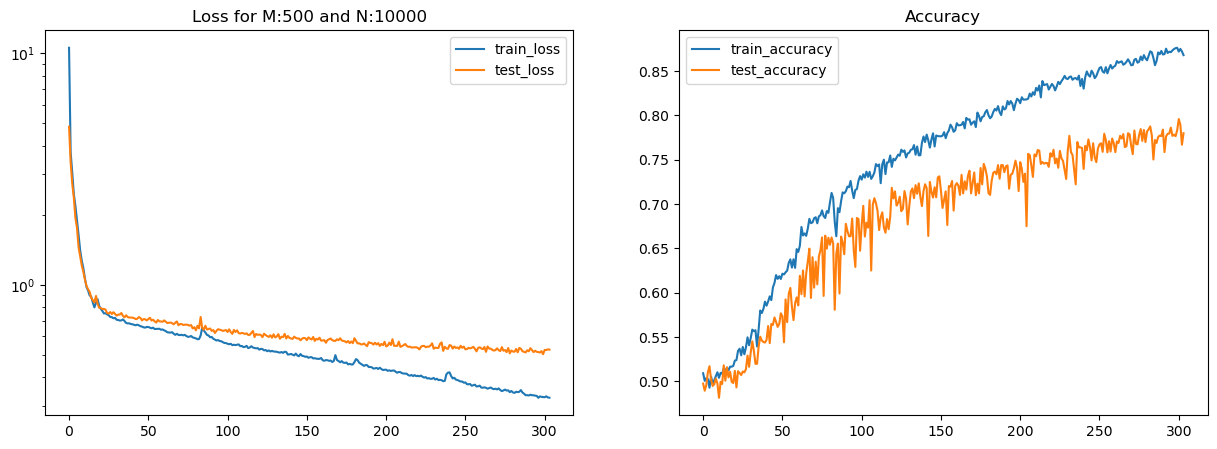

KeyboardInterrupt: 

In [24]:
# Early stopping parameters
patience = 30 # Number of epochs to wait for improvement
epochs = 1000 # Maximum number of epochs

batch_size = N//n_batch #min(N//10, 1000)

model, metrics_history, key = nntr.train_loop(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    key=key,
    epochs=epochs,
    batch_size=batch_size,
    patience=patience,
    metrics_history=metrics_history,
    M=M,
    N=N,
    plot_flag=True     # set to False to disable plotting
)


# Test NN

## Test Accuracy

In [25]:
model.eval()  # disable dropout, etc.

batch_size = 128  # tune this to fit your RAM; lower → safer

# Accumulators
all_logits = []
all_labels = []

# Loop over your test set in-place
num_samples = test_data.shape[0]
for i in range(0, num_samples, batch_size):
    xb = test_data[i : i + batch_size]
    yb = test_labels[i : i + batch_size]

    # Get logits for this mini-batch
    logits = nntr.pred_step(model, xb)
    all_logits.append(logits)

    # Store the corresponding true labels
    all_labels.append(yb > 0.5)

# Merge everything back together
all_logits = jnp.concatenate(all_logits, axis=0)
all_preds  = jsp.special.expit(all_logits) > 0.5
all_labels = jnp.concatenate(all_labels, axis=0)

# === same metrics computation as before ===
TP = jnp.sum((all_preds == 1) & (all_labels == 1))
TN = jnp.sum((all_preds == 0) & (all_labels == 0))
FP = jnp.sum((all_preds == 1) & (all_labels == 0))
FN = jnp.sum((all_preds == 0) & (all_labels == 1))

print(f"True positives : {TP}")
print(f"True negatives : {TN}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}\n")

accuracy    = (TP + TN) / (TP + TN + FP + FN)
precision   = TP / (TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy   : {accuracy:.3f}")
print(f"Precision  : {precision:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

True positives : 1352
True negatives : 1035
False positives: 457
False negatives: 156

Accuracy   : 0.796
Precision  : 0.747
Sensitivity: 0.897
Specificity: 0.694


## Test TARP

In [26]:
# ========== Run TARP test ==========
model.eval()

param_names = list(bounds.keys())
NDIM = len(param_names)
BOUNDS = jnp.array([[bounds[name]['min'], bounds[name]['max']] for name in param_names])


# Select samples with true parameters in the test set
mask_true = test_labels[:, 0] == 1
xy_test = test_data[mask_true, :-NDIM]
theta_star = test_data[mask_true, -NDIM:]
N_sims = int(jnp.minimum(100, jnp.sum(test_labels)))
xy_test = xy_test[:N_sims, :]
theta_star = theta_star[:N_sims, :]




In [ ]:
alpha_grid = jnp.linspace(0, 1, 50)

if backend == "METAL":
    # METAL GPU branch
    print("Launching MCMC (JIT‐compiled) on METAL GPU...")
    with jax.default_device(cpu):      # gpu is your METAL device
        ecp, post, key = nnte.compute_ecp_tarp_jitted_with_progress(
            model, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS
        )
    print("MCMC finished on METAL")

elif backend == "cuda":
    # CUDA GPU branch
    print("Launching MCMC (JIT‐compiled) on CUDA GPU...")
    with jax.default_device(gpu):      # gpu is your CUDA device
        ecp, f_vals, post, key = nnte.compute_ecp_tarp_jitted(
            model, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS
        )
    print("MCMC finished on CUDA")

else:
    # CPU fallback
    print("Launching MCMC (JIT‐compiled) on CPU...")
    with jax.default_device(cpu):
        ecp, post, key = nnte.compute_ecp_tarp_jitted_with_progress(
            model, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS
        )
    print("MCMC finished on CPU")

Launching MCMC (JIT‐compiled) on CPU...


Computing ECP batches:   0%|          | 0/5 [00:00<?, ?it/s]

MCMC finished


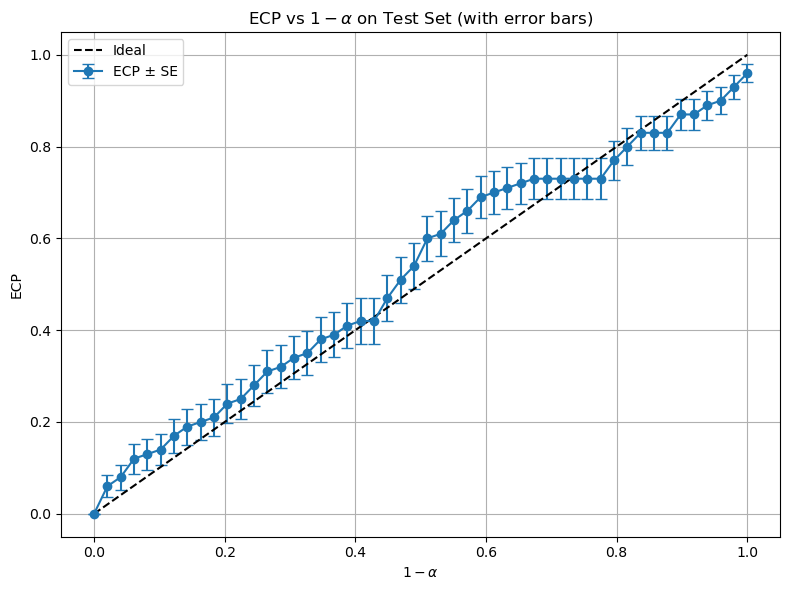

In [28]:
# Example: 1 - alpha grid and computed ecp
alpha_grid = jnp.array(alpha_grid)
ecp = jnp.array(ecp)

# Compute standard error for binomial proportion
se = jnp.sqrt(ecp * (1 - ecp) / N_sims) #https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wald_interval

# CHECK HOW TO COMPUTE THE ERROR

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(1 - alpha_grid, ecp, yerr=se, fmt='o-', capsize=4, label='ECP ± SE')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
plt.xlabel(r'$1 - \alpha$')
plt.ylabel("ECP")
plt.title("ECP vs $1 - \\alpha$ on Test Set (with error bars)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Test posterior

In [35]:
print(theta_star[1,:])

[-0.08347316  2.8852901   0.0801193  -0.45422173]


In [29]:
test_data = xy_test[1,:]

with jax.default_device(cpu):
    def log_post(theta):
            return nnte.log_prob_fn(theta, model, test_data, BOUNDS)

    # Initial position at the middle of the priors from bounds
    theta_init = (BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0

    print("Launch MCMC ...")
    # Run MCMC
    key, post = nnte.sample_posterior(
        log_post,
        n_warmup=1000,
        n_samples=2000,
        init_position = theta_init,
        rng_key=key
    )

print("...finished")

Launch MCMC ...
...finished


In [30]:
# import numpy as np

# samples = post.at[:, 2].add(19.3)  # does not copy unnecessarily
# samples_np = np.array(samples)     # only one device-to-host copy

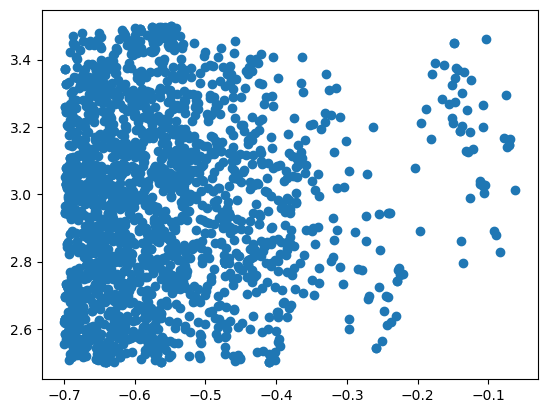

In [33]:
plt.scatter(post[:,3], post[:,1])
plt.show()

# Save NN to disk

In [26]:
# Save the trained model for future use
nntr.save_nn(model,'../data/NNs/nn_model', model_config)